In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

In [2]:
def save(submission):
    valid = pd.read_csv("../data/test.csv")
    val_ids = valid["Id"]
    g = {'Id': val_ids.to_numpy(), 'Expected': submission}
    gf = pd.DataFrame(data=g)
    gf.to_csv('..\submission\submission.csv', index=False)

In [3]:
def dropСol(data):
    if "Id" in data:
        data = data.drop(columns = ["Id"])
    elif "Sales" in data:
        data = data.drop(columns=["Sales"])
    return data.drop(columns=["Color", "Name"])

In [4]:
def getAveragePrice(x):
    if np.isnan(x['Average price']):
        return (0.5 * (x['Min price'] + x['Max price']))
    return x['Average price']

In [5]:
data = pd.read_csv("../data/train.csv")
X = data
y = data["Sales"]
X['Rating'] = X['Rating'].str.replace(',','.').astype(float)
X['Average price'] = data.apply(lambda x : getAveragePrice(x), axis=1).astype(float)
X = dropСol(X)
X.fillna('Nan', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.67, random_state=42)
X_train.head()

,Category,Brand,Seller,Comments,Final price,Max price,Min price,Average price,Days in stock,Days with sales,Rating,Basic Sale,Basic Sale Price,Base price,full_category
4439,/Техника для кухни/Приготовление напитков/Турк...,Kelli,ЭКО-ПОСТАВКА ООО,2.0,1030.0,1030.0,1030.0,1030.0,3.0,1,3.0,40.0,1374.0,2290.0,Бытовая техника/Техника для кухни/Приготовлени...
12198,/Красота и здоровье/Эпиляторы/Эпиляторы,NAC,Ахмади Басер ИП,2.0,232.0,232.0,232.0,232.0,26.0,18,3.0,75.0,249.0,999.0,Бытовая техника/Красота и здоровье/Эпиляторы/Э...
20654,/Красота и здоровье/Бритвы и триммеры/Триммеры...,Imetec,"Филиал АО «ТЕНАКТА ГРУП С.П.А.» (Италия) в РФ,...",3.0,2092.0,2092.0,2092.0,2092.0,31.0,5,3.0,35.0,2989.0,4599.0,Бытовая техника/Красота и здоровье/Бритвы и тр...
4690,"/Красота и здоровье/Фены, приборы для укладки/...",DARI Home,Авдонкина Виктория Григорьевна,0.0,1672.0,1672.0,1672.0,1672.0,0.0,0,0.0,75.0,1672.0,6688.0,"Бытовая техника/Красота и здоровье/Фены, прибо..."
1558,/Красота и здоровье/Бритвы и триммеры/Бритвы э...,CENTEK,ЛИВСИТИ ООО,13.0,2367.0,2367.0,2367.0,2367.0,27.0,13,4.0,15.0,2367.0,2785.0,Бытовая техника/Красота и здоровье/Бритвы и тр...


In [6]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)
params = {
    'learning_rate': 0.2,
    'eval_metric': 'SMAPE',
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'MAPE',
    'one_hot_max_size': 20,
    'l2_leaf_reg': 30,
    'depth': 8,
    'rsm': 0.6,
}
cat_model = CatBoostRegressor(**params)
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=False, early_stopping_rounds=50)

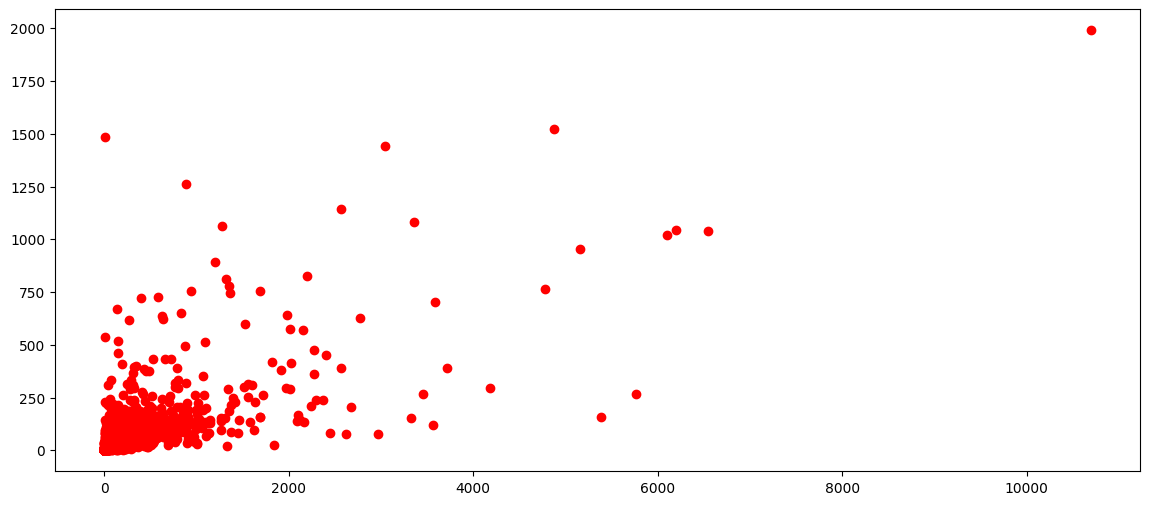

In [7]:
plt.figure(figsize=(14,6))
plt.scatter(y_test, cat_model.predict(X_test), color='red')

In [8]:
test_data = pd.read_csv("../data/test.csv")
test_data['Rating'] = test_data['Rating'].str.replace(',','.').astype(float)
test_data['Average price'] = data.apply(lambda x : getAveragePrice(x), axis=1).astype(float)
test_data = dropСol(test_data)
test_data.fillna('Nan', inplace=True)
test_data.head()

,Category,Brand,Seller,Comments,Final price,Max price,Min price,Average price,Days in stock,Days with sales,Rating,Basic Sale,Basic Sale Price,Base price,full_category
0,/Техника для кухни/Приготовление напитков/Помп...,Majava,Бобров Вячеслав Юрьевич,2.0,277.0,277.0,250.0,41555.000000,16.0,14,0.0,50.0,360.0,720.0,Бытовая техника/Техника для кухни/Приготовлени...
1,/Техника для кухни/Приготовление напитков/Терм...,Beon,ТЕХПРОМ ООО,5.0,2211.0,2211.0,2211.0,799.000000,7.0,8,3.0,40.0,2664.0,4440.0,Бытовая техника/Техника для кухни/Приготовлени...
2,/Техника для дома/Аксессуары для пылесосов/Фил...,NEOLUX,ПКФ НЕВА-ФИЛЬТР ООО,19.0,490.0,490.0,450.0,550.000000,31.0,22,5.0,30.0,490.0,700.0,Бытовая техника/Техника для дома/Аксессуары дл...
3,/Красота и здоровье/Косметические аппараты/Апп...,CENTEK,ЛИВСИТИ ООО,2.0,807.0,807.0,807.0,127.000000,31.0,0,4.0,15.0,807.0,950.0,Бытовая техника/Красота и здоровье/Косметическ...
4,/Техника для дома/Пульты управления/Пульты тел...,HUAYU,Дулгер Дарья Сергеевна ИП,3.0,426.0,440.0,426.0,4595.595745,31.0,5,5.0,3.0,426.0,440.0,Бытовая техника/Техника для дома/Пульты управл...


In [9]:
result = cat_model.predict(test_data)

save(result)